# **Detecting Hallucinations in LLMs using Semantic Entropy**
This notebook implements techniques from the 2024 Nature paper "Detecting Hallucinations in Large Language Models using Semantic Entropy", presented at AJCAI 2024 in Melbourne, Australia. The paper introduces entropy-based methods for detecting hallucinations in LLM outputs — a crucial step toward building safer and more reliable AI systems.

🚀 **Objective**

To detect when large language models generate unfaithful or unsupported information (hallucinations), especially in tasks like question answering.


In [ ]:
!pip install evaluate

In [1]:
# Configurable parameters
import pickle 
from evaluate import load
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import random 
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

import numpy as np

# Load model and tokenizer entailment
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch.nn import functional as F
import gc

from sklearn.metrics import roc_auc_score, RocCurveDisplay
from matplotlib import pyplot as plt
import seaborn as sns
from collections import defaultdict


random.seed(100)

class config():
    max_new_tokens=1000
    temperature=1
    output_scores=True
    output_hidden_states=True
    do_sample=True
    skip_special_tokens=True
    return_dict_in_generate=True
    stop_sequences=['\n\n\n\n', '\n\n\n', '\n\n', '\n', 'Question:', 'Context:']
    num_samples=1 # increase this parameter to get better generalization
    num_generations=3 # number of answers generated for each prompt

In [2]:
# Utils functions

def save_object(object, file_name):
    with open(f'/kaggle/working/{file_name}', 'wb') as f:
        pickle.dump(object, f)

📚 **Dataset**

The experiments are conducted on SQuAD 2.0, a challenging reading comprehension dataset containing both answerable and unanswerable questions derived from Wikipedia. The approach can generalize to other QA datasets like Natural Questions and TriviaQA.

In [3]:


dataset = load_dataset("squad_v2")
train_dataset = dataset["train"]
validation_dataset = dataset["validation"] # we will test on validation set only

README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [4]:
train_df = train_dataset.to_pandas()
train_df.head()

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,"{'text': ['2003'], 'answer_start': [526]}"
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,"{'text': ['Houston, Texas'], 'answer_start': [..."
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,"{'text': ['late 1990s'], 'answer_start': [276]}"


In [5]:
train_df.loc[0, 'answers']

{'text': array(['in the late 1990s'], dtype=object),
 'answer_start': array([269], dtype=int32)}

In [6]:
train_df.loc[0, 'context'][269:]

'in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [7]:
train_dataset[0]

{'id': '56be85543aeaaa14008c9063',
 'title': 'Beyoncé',
 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
 'question': 'When did Beyonce start becoming popular?',
 'answers': {'text': ['in the late 1990s'], 'answer_start': [269]}}

**2. Loading model**
* Mistral-7B: the most powerful language model for its size to date (Oct. 2023)


 **Loading model and tokenizer**

You’re loading a causal language model (Mistral 7B Instruct) along with its tokenizer from local checkpoints, using the Hugging Face Transformers library. The tokenizer is a causal LM tokenizer designed to prepare input text for autoregressive generation tasks. The model and tokenizer are both loaded with automatic device mapping to efficiently use available GPUs.

In [8]:



device = "cuda" # the device to load the model onto

model = AutoModelForCausalLM.from_pretrained(
    "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1", 
    device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(
    "/kaggle/input/mistral/pytorch/7b-instruct-v0.1-hf/1",
    device_map='auto'
)

2025-06-09 08:27:09.107715: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749457629.340094      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749457629.401806      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
def prompt_construction(question, context=''):
    """Construct prompt from question and context"""
    
    prompt = 'Answer the following question with provided as briefly as possible.\n'
    if context:
        prompt += f'Context: {context}\n'
    
    prompt += f'Question: {question}\n'
    prompt += 'Answer:'
        
    return prompt

In [10]:
sample_question = 'What is the capital of France?'
input_data = prompt_construction(sample_question)
print(input_data)

Answer the following question with provided as briefly as possible.
Question: What is the capital of France?
Answer:


In [11]:
# 1. Tokenize the input
inputs = tokenizer(input_data, return_tensors="pt").to(device)

# 2. Generate and decode output
outputs = model.generate(
    inputs.input_ids,
    max_new_tokens=config.max_new_tokens,
    return_dict_in_generate=config.return_dict_in_generate,
    output_scores=config.output_scores,
    output_hidden_states=config.output_hidden_states,
    temperature=config.temperature,
    do_sample=config.do_sample,
    pad_token_id=tokenizer.eos_token_id
)

full_answer = tokenizer.decode(outputs.sequences[0], skip_special_tokens=config.skip_special_tokens)
print(full_answer)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Answer the following question with provided as briefly as possible.
Question: What is the capital of France?
Answer: The capital of France is Paris.


In [12]:
def get_model_prediction(input_data, model, tokenizer, device, temperature):
    """
    """
    # 1. Tokenize the input
    inputs = tokenizer(input_data, return_tensors="pt").to(device)

    # 2. Generate and decode output
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=config.max_new_tokens,
        return_dict_in_generate=config.return_dict_in_generate,
        output_scores=config.output_scores,
        output_hidden_states=config.output_hidden_states,
        temperature=temperature,
        do_sample=config.do_sample,
        pad_token_id=tokenizer.eos_token_id
    )
    
    full_answer = tokenizer.decode(
        outputs.sequences[0], 
        skip_special_tokens=config.skip_special_tokens)
    
    # 3. Post processing answer
    # - Remove input from answer.
    if full_answer.startswith(input_data):
        input_data_offset = len(input_data)
        answer = full_answer[input_data_offset:]
    else:
        answer = full_answer

    # - Remove stop_words from answer.
    stop_at = len(answer)
    sliced_answer = answer
    if config.stop_sequences is not None:
        for stop in config.stop_sequences:
            if answer.endswith(stop):
                stop_at = len(answer) - len(stop)
                sliced_answer = answer[:stop_at]
                break

    # - Remove whitespaces from answer (in particular from beginning.)
    sliced_answer = sliced_answer.strip()

    # 4. Get the last hidden state and the last token's embeddings of the answer
    # - Get the number of tokens until the stop word comes up.
    token_stop_index = tokenizer(full_answer[:input_data_offset + stop_at], return_tensors="pt")['input_ids'].shape[1]
    n_input_token = len(inputs['input_ids'][0])
    n_generated = token_stop_index - n_input_token

    if n_generated == 0:
        # Only stop_words were generated. For likelihoods and embeddings, taking stop word instead.
        n_generated = 1

    # outputs.hidden_state is a tuple of len = n_generated_tokens.
    # The first hidden state is for the input tokens and is of shape
    #     (n_layers) x (batch_size, input_size, hidden_size).
    # (Note this includes the first generated token!)
    # The remaining hidden states are for the remaining generated tokens and is of shape
    #    (n_layers) x (batch_size, 1, hidden_size).

    # Note: The output embeddings have the shape (batch_size, generated_length, hidden_size).
    # We do not get embeddings for input_data! We thus subtract the n_tokens_in_input from
    # token_stop_index to arrive at the right output.

    hidden = outputs.hidden_states
    if len(hidden) == 1:
        # Taking first and only generation for hidden!
        last_input = hidden[0]
    elif (n_generated - 1) >= len(hidden):
        # If access idx is larger/equal --> Taking last state because n_generated is too large
        last_input = hidden[-1]
    else:
        last_input = hidden[n_generated - 1]

    # - Then access last layer and token in input
    last_layer = last_input[-1]
    last_token_embedding = last_layer[:, -1, :].cpu()

    # 5. Get log_likelihoods.
    # - outputs.scores are the logits for the generated token.
    # - outputs.scores is a tuple of len = n_generated_tokens.
    # - Each entry is shape (bs, vocabulary size).
    # - outputs.sequences is the sequence of all tokens: input and generated.
    transition_scores = model.compute_transition_scores(
        outputs.sequences, outputs.scores, normalize_logits=True)
    # Transition_scores[0] only contains the scores for the first generated tokens.

    log_likelihoods = [score.item() for score in transition_scores[0]]
    if len(log_likelihoods) == 1:
        # Taking first and only generation for log likelihood!
        log_likelihoods = log_likelihoods
    else:
        log_likelihoods = log_likelihoods[:n_generated]

    if len(log_likelihoods) == 0:
        raise ValueError

    return sliced_answer, log_likelihoods, last_token_embedding

**Uncertainty estimation**

In [13]:


def get_reference(example):
    if 'answers' not in example:
        example = example['reference']
    answers = example['answers']
    answer_starts = answers.get('answer_start', [])
    reference = {'answers': {'answer_start': answer_starts, 'text': answers['text']}, 'id': example['id']}
    
    return reference


def get_metric(response, example):
    # Compatibility with recomputation.
    if 'id' in example:
        exid = example['id']
    elif 'id' in example['reference']:
        exid = example['reference']['id']
    else:
        raise ValueError

    prediction = {'prediction_text': response, 'no_answer_probability': 0.0, 'id': exid}
    
    squad_metric = load("squad_v2")
    results = squad_metric.compute(
        predictions=[prediction],
        references=[get_reference(example)])
    
    return 1.0 if (results['f1'] >= 50.0) else 0.0


def calculate_p_true(question, most_probable_answer, brainstormed_answers):
    """Calculate p_true uncertainty metric."""

    prompt = ''
    prompt += 'Question: ' + question
    prompt += '\nBrainstormed Answers: '
    for answer in brainstormed_answers + [most_probable_answer]:
        prompt += answer.strip() + '\n'
    prompt += 'Possible answer: ' + most_probable_answer + '\n'
    prompt += 'Is the possible answer:\n'
    prompt += 'A) True\n'
    prompt += 'B) False\n'
    prompt += 'The possible answer is:'

    """Get the probability of the model anwering A (True) for the given input."""

    prompt += ' A' # ... the possible answer is A --> get probability of A
    tokenized_prompt_true = tokenizer(prompt, return_tensors='pt').to(device)['input_ids']
    # The computation of the negative log likelihoods follows:
    # https://huggingface.co/docs/transformers/perplexity.

    target_ids_true = tokenized_prompt_true.clone() 
    # Set all target_ids except the last one to -100.
    target_ids_true[0, :-1] = -100

    with torch.no_grad():
        model_output_true = model(tokenized_prompt_true, labels=target_ids_true)

    loss_true = model_output_true.loss 

    return -loss_true.item()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn

In [14]:
# This will store all input data and model predictions.
accuracies, generations, results_dict = [], {}, {}

dataset = validation_dataset # we will test our model on validation set only
possible_indices = range(0, len(dataset))
    
# Evaluate over random subset of the datasets.
indices = random.sample(possible_indices, min(config.num_samples, len(dataset)))

accuracies, generations, results_dict, p_trues = [], {}, {}, []
it = 0
for index in tqdm(indices):
    if (it + 1 % 10) == 0:
        gc.collect()
        # torch.cuda.empty_cache()
    it += 1

    # Grab example at index.
    example = dataset[index]
    question, context = example['question'], example['context']
    generations[example['id']] = {'question': question, 'context': context}
    correct_answer = example['answers']['text']
    current_input = prompt_construction(question=question, context=context)

    full_responses = []

    # We sample one low temperature answer on which we will compute the
    # accuracy and args.num_generation high temperature answers which will
    # be used to estimate the entropy variants.
    
    for i in range(config.num_generations):

        # Temperature for first generation is always `0.1`.
        temperature = 0.1 if i == 0 else config.temperature

        predicted_answer, token_log_likelihoods, embedding = get_model_prediction(
            input_data=current_input, 
            model=model, 
            tokenizer=tokenizer, 
            device=device, 
            temperature=temperature
        )
        
        embedding = embedding.cpu() if embedding is not None else None

        # Only compute accuracy if question is answerable.
        acc = get_metric(predicted_answer, example)
        if i == 0:
            accuracies.append(acc)
            most_likely_answer_dict = {
                'response': predicted_answer,
                'token_log_likelihoods': token_log_likelihoods,
                'embedding': embedding,
                'accuracy': acc}
            
            generations[example['id']].update({
                'most_likely_answer': most_likely_answer_dict,
                'reference': get_reference(example)})

        else:
            # Aggregate predictions over num_generations.
            full_responses.append(
                (predicted_answer, token_log_likelihoods, embedding, acc)
            )

    # Append all predictions for this example to `generations`.
    generations[example['id']]['responses'] = full_responses
    
    # Calculate p(True) on validation set
    p_true = calculate_p_true(
        question, most_likely_answer_dict['response'],
        [r[0] for r in full_responses],
    )
    p_trues.append(p_true)
        
results_dict['uncertainty_measures'] = {
    # 'p_false':  [1 - p for p in p_trues],
    'p_false_fixed':  [1 - np.exp(p) for p in p_trues], # normalize
}

# Save objects
save_object(results_dict, 'uncertainty_measures.pkl')
save_object(generations,  'generations.pkl')

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:07<00:00,  7.93s/it]


Naive entropy

In [15]:
def predictive_entropy_mc(log_probs):
    """Compute MC estimate of entropy.

    `E[-log p(x)] ~= -1/N sum_i log p(x_i)`, i.e. the average token likelihood.
    """
    entropy = - np.sum(log_probs) / len(log_probs)
    
    return entropy

In [16]:
def predictive_entropy_rao(log_probs):
    entropy = -np.sum(np.exp(log_probs) * log_probs)
    return entropy

Semantic Entropy

**entail_tokenizer**: This is the tokenizer for DeBERTa-v3-xsmall, which converts input text pairs into token IDs and attention masks that the model can understand.

**entail_model**: This is a DeBERTa-v3-xsmall model fine-tuned for sequence classification (like natural language inference). It takes tokenized inputs and predicts whether one sentence entails, contradicts, or is neutral to the other.

In [20]:

gc.collect()
torch.cuda.empty_cache()

entail_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/huggingfacedebertav3variants/deberta-v3-xsmall")
entail_model = AutoModelForSequenceClassification.from_pretrained(
    "/kaggle/input/huggingfacedebertav3variants/deberta-v3-xsmall").to(device)

def semantic_clustering(text1, text2):
    """
        The model checks if text1 -> text2, i.e. if text2 follows from text1.
        Eg1: semantic_clustering('The weather is good', 'The weather is good and I like you') --> 1
        Eg2: semantic_clustering('The weather is good and I like you', 'The weather is good') --> 2
    """
 
    inputs = entail_tokenizer(text1, text2, return_tensors="pt").to(device)
    outputs = entail_model(**inputs)
    logits = outputs.logits
    
    # Deberta-mnli returns `neutral` and `entailment` classes at indices 1 and 2.
    largest_index = torch.argmax(F.softmax(logits, dim=1))
    prediction = largest_index.cpu().item()

    return prediction


def are_equivalent(text1, text2, strict_entailment=False):
    """
        Check if two text are equivalent in terms of meaning, based on entailment
    """
    
    implication_1 = semantic_clustering(text1, text2,)
    implication_2 = semantic_clustering(text2, text1) 
    assert (implication_1 in [0, 1, 2]) and (implication_2 in [0, 1, 2])

    if strict_entailment:
        semantically_equivalent = (implication_1 == 2) and (implication_2 == 2)

    else:
        implications = [implication_1, implication_2]
        # Check if none of the implications are 0 (contradiction) and not both of them are neutral.
        semantically_equivalent = (0 not in implications) and ([1, 1] != implications)

    return semantically_equivalent

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/huggingfacedebertav3variants/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Example of using semantic clustering
# Smallest version of datasets for demo. Bigger models could be experimented on larger servers
# Expect: deberta-large-v2-mnli
# Label: ['contradiction', 'neutral', 'entailment']
print(semantic_clustering('The weather is good', 'The weather is good and I like you')) # --> 1
print(are_equivalent('The weather is good', 'The weather is good and I like you')) 

print(semantic_clustering('The weather is good and I like you', 'The weather is good')) # --> 2
print(are_equivalent('The weather is good and I like you', 'The weather is good'))

0
False
0
False


This function groups log-likelihoods by their semantic cluster IDs and computes the combined log-probability for each cluster using the log-sum-exp trick. It sums probabilities (in log space) of all items sharing the same semantic ID to get one aggregated log-likelihood per cluster.

In [23]:
def logsumexp_by_id(semantic_ids, log_likelihoods):
    """Sum probabilities with the same semantic id.

    Log-Sum-Exp because input and output probabilities in log space.
    """
    unique_ids = sorted(list(set(semantic_ids)))
    assert unique_ids == list(range(len(unique_ids)))
    log_likelihood_per_semantic_id = []

    for uid in unique_ids:
        # Find positions in `semantic_ids` which belong to the active `uid`.
        id_indices = [pos for pos, x in enumerate(semantic_ids) if x == uid]

        # Gather log likelihoods at these indices.
        id_log_likelihoods = [log_likelihoods[i] for i in id_indices]
        log_lik_norm = np.log(np.sum(np.exp(id_log_likelihoods)))

        log_likelihood_per_semantic_id.append(log_lik_norm)

    return log_likelihood_per_semantic_id

In [24]:
def cluster_assignment_entropy(semantic_ids):
    """Estimate semantic uncertainty from how often different clusters get assigned.

    We estimate the categorical distribution over cluster assignments from the
    semantic ids. The uncertainty is then given by the entropy of that
    distribution. This estimate does not use token likelihoods, it relies soley
    on the cluster assignments. If probability mass is spread of between many
    clusters, entropy is larger. If probability mass is concentrated on a few
    clusters, entropy is small.

    Input:
        semantic_ids: List of semantic ids, e.g. [0, 1, 2, 1].
    Output:
        cluster_entropy: Entropy, e.g. (-p log p).sum() for p = [1/4, 2/4, 1/4].
    """

    n_generations = len(semantic_ids)
    counts = np.bincount(semantic_ids)
    probabilities = counts/n_generations
    assert np.isclose(probabilities.sum(), 1)
    entropy = - (probabilities * np.log(probabilities)).sum()
    
    return entropy

In [25]:


results_dict['semantic_ids'] = []
    
entropies = defaultdict(list)
validation_embeddings, validation_is_true, validation_answerable = [], [], []
count = 0  # pylint: disable=invalid-name

def is_answerable(generation):
    return len(generation['reference']['answers']['text']) > 0

# Loop over datapoints and compute validation embeddings and entropies.
for idx, tid in enumerate(generations):

    example = generations[tid]
    question = example['question']
    context = example['context']
    full_responses = example['responses']
    most_likely_answer = example['most_likely_answer']

    responses = [fr[0] for fr in full_responses]

    validation_is_true.append(most_likely_answer['accuracy'])

    validation_answerable.append(is_answerable(example))
    validation_embeddings.append(most_likely_answer['embedding'])

    # Token log likelihoods. Shape = (n_sample, n_tokens)
    log_liks = [r[1] for r in full_responses]

    for i in log_liks:
        assert i

    # Compute semantic ids.
    semantic_ids = get_semantic_ids(responses)

    results_dict['semantic_ids'].append(semantic_ids)

    # Compute entropy from frequencies of cluster assignments.
    entropies['cluster_assignment_entropy'].append(cluster_assignment_entropy(semantic_ids))

    # Length normalization of generation probabilities.
    log_liks_agg = [np.mean(log_lik) for log_lik in log_liks]

    # Compute naive entropy.
    entropies['regular_entropy_mc'].append(predictive_entropy_mc(log_liks_agg))

    # Compute semantic entropy.
    log_likelihood_per_semantic_id = logsumexp_by_id(semantic_ids, log_liks_agg) # with normalization
    pe = predictive_entropy_rao(log_likelihood_per_semantic_id)
    entropies['semantic_entropy'].append(pe)

results_dict['uncertainty_measures'].update(entropies)
validation_is_false = [1.0 - is_t for is_t in validation_is_true]
results_dict['validation_is_false'] = validation_is_false

save_object(results_dict, 'uncertainty_measures.pkl')

# We could check the score for particular prediction here
pd.DataFrame(results_dict['uncertainty_measures']).head()

,p_false_fixed,cluster_assignment_entropy,regular_entropy_mc,semantic_entropy
0,0.676718,0.693147,0.991886,0.697548


**Results**

In [27]:
# Load saved results


with open(f'/kaggle/input/saved-results/uncertainty_measures.pkl', 'rb') as f:
    results_dict = pickle.load(f)

You’re plotting ROC curves to compare different uncertainty measures (like entropy and p(True)) in detecting hallucinated answers. This shows how well each method distinguishes correct from incorrect responses, helping evaluate which metric is best for hallucination detection.

Text(0.5, 1.0, 'Evaluation metrics of hallucination detectors')

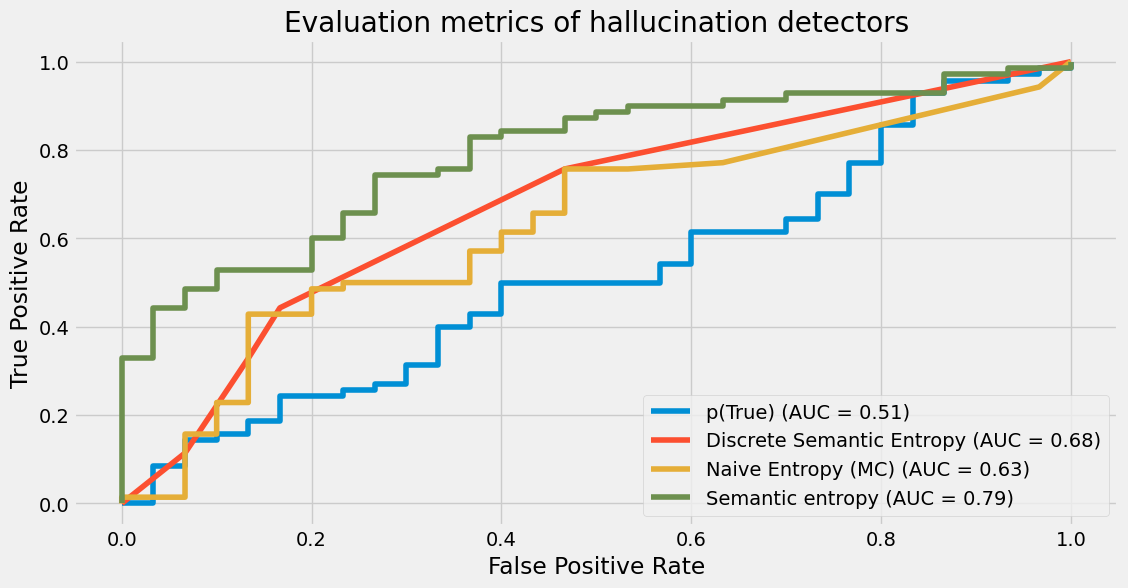

In [28]:
#--------------------------------Visualization------------------------------------


plt.style.use('fivethirtyeight')

plt.figure(figsize=(12, 6))
ax = plt.gca()

method_mapping = {
    'semantic_entropy': 'Semantic entropy', 
    'cluster_assignment_entropy': 'Discrete Semantic Entropy', 
    'regular_entropy_mc': 'Naive Entropy (MC)',
    'p_false_fixed': 'p(True)'
}

for measure_name, measure_values in results_dict['uncertainty_measures'].items():
    measure_name_friendly = method_mapping[measure_name]
    RocCurveDisplay.from_predictions(results_dict['validation_is_false'], measure_values, name=measure_name_friendly, ax=ax)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Evaluation metrics of hallucination detectors')